In [1]:
#installing pytesseract
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install tensorflow-text

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from drive.MyDrive.Applied_ai import sentiment    #importing python module

import tensorflow as tf
from tensorflow import keras
import tensorflow_text as text
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import load_model

import json
import pickle

from PIL import Image
import cv2 
from skimage import io
import pytesseract

from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [6]:
#reading the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Applied_ai/test dataset/df_final_test.csv')

In [7]:
#loading pre trained model and word index
pred_model = keras.models.load_model('/content/drive/MyDrive/Applied_ai/best_model.hdf5')
word_idx = json.load(open("/content/drive/MyDrive/Applied_ai/word_idx.txt"))
img_feature_model = VGG16()

In [8]:
#range of HSV values to extract colors from the image
boundries = [([0,0,200],[180,25,255]),      #white
              ([0,0,0],[180,255,3]),        #black
              ([0,0,100],[180,20,180]),        #gray
              ([0,90,115],[17,255,190]),     #brown
              ([20,50,240],[30,75,255]),     #off-white
              ([0,140,155],[12,255,230]),      #dark red
              ([0,140,230],[12,255,255]),     #light red
              ([13,190,155],[17,255,230]),     #dark orange
              ([13,140,230],[115,255,255]),    #light orange
              ([18,140,155],[140,255,230]),     #goldish
              ([23,140,230],[165,255,255]),    #yellow
              ([28,90,155],[80,255,230]),    #dark green
              ([85,77,153],[93,255,230]),   #dark cyan
              ([85,77,230],[93,255,255]),  #cyan
              ([100,128,90],[125,255,190]),   #dark blue
              ([100,128,193],[125,255,255]),  #light blue
              ([0,0,255],[180,25,255])      #faded colors
]

<br>

# **First Function**

In [18]:
def function_1(data):
  
  df = data
  
  #lists to store extracted data from image
  img_text = []
  avg_h = []
  avg_s = []
  avg_v = []
  all_colors = []
  width = []
  height = []
  img_feature_pred_1 = []
  img_feature_pred_2 = []
  img_feature_pred_3 = []
  website = []
  book_jacket = []
  packet = []
  mud_turtle = []

  print("\n\nPreparing data...\n")
  #extracting data from images
  for url in tqdm(data['url'], position=0):

    path = '/content/drive/MyDrive/Applied_ai/meme_images/'+url
    im = io.imread(path)

    #extracting text
    im_t = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im_t = cv2.threshold(im_t, 127, 255, cv2.THRESH_BINARY) 
    custom_config = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    text = pytesseract.image_to_string(im_t, lang='eng', config=custom_config)
    #print('text length',len(text.split(' ')))
    text = text.replace('\n', ' ')

    #cleaning text
    text = re.sub('[^A-Za-z]',' ',text).lower()
    words = nltk.word_tokenize(text)
    stopWords = set(stopwords.words('english'))
    words = [w for w in words if w not in stopWords and len(w)>3]
    img_text.append(' '.join(words))
    
    #extracting HSV
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    avg_h.append(h.mean())
    avg_s.append(s.mean())
    avg_v.append(v.mean())
    
    #extracting colors from image
    num_pixel = im.shape[0] * im.shape[1]
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    clr_pixel = []

    for (lower, upper) in boundries:
      lower = np.array(lower, dtype = "uint8")
      upper = np.array(upper, dtype = "uint8")
      mask = cv2.inRange(hsv, lower, upper)
      clr_pixel.append(round(((mask==255).sum())/num_pixel,5)) #counting and normalizing number of pixels

    all_colors.append(clr_pixel)
    
    #getting height and width of the image
    hgt = im.shape[0]
    wth = im.shape[1]
    width.append(wth)
    height.append(hgt)
    
    #extracting objects from image using VGG16
    
    pixels = np.asarray(im)
    pixels = pixels.astype('float32')
    pixels.resize(224,224,3)
    pixels = np.expand_dims(pixels, axis=0)
    pixels = preprocess_input(pixels)
    im_prediction = img_feature_model.predict(pixels)
    labels = decode_predictions(im_prediction, top=3)
    
    img_feature_pred_1.append(labels[0][0][2])
    img_feature_pred_2.append(labels[0][1][2])
    img_feature_pred_3.append(labels[0][2][2])

    objects = [labels[0][0][1],labels[0][1][1],labels[0][2][1]]
    for j in ['website','book_jacket','packet','mud_turtle']:
        if j in objects:
          exec("%s.append(%d)" % (j,1))
        else:
          exec("%s.append(%d)" % (j,0))

    
  """combining extracted features from images to the dataset"""
  
  #text data
  df['text'] = img_text
  
  #feature containing number of words in text
  df['num_words'] = df['text'].str.split().apply(len)
  
  #getting sentiment score of the text data
  df = sentiment.get_sentiment(pred_model, df, word_idx)
  
  #getting HSV value
  df['avg_h'] = avg_h
  df['avg_s'] = avg_s
  df['avg_v'] = avg_v

  #colors
  colors = ['white','black','gray','brown','off-white','dark red','light red','dark orange','light orange',
          'goldish','yellow','dark green','dark cyan','cyan','dark blue','light blue','faded colors']
  #adding new color features to the dataset
  for i, color in enumerate(colors):
    df[color] = np.matrix(all_colors)[:,i]

  #thumbnail height and width
  df['thumbnail_height'] = height
  df['thumbnail_width']  = width

  #probability of occurance of objects in the image
  df['img_feature_pred_1'] = img_feature_pred_1
  df['img_feature_pred_2'] = img_feature_pred_2
  df['img_feature_pred_3'] = img_feature_pred_3

  #objects in the image
  df['web_site'] = website
  df['book_jacket'] = book_jacket
  df['packet'] = packet
  df['mud_turtle'] = mud_turtle

  """Defining different features for our different models"""

  #dataset for ML model
  X_ml = df[['img_feature_pred_1','img_feature_pred_2','img_feature_pred_3','avg_h','avg_s','avg_v','Sentiment_Score','hour',
    'num_words','thumbnail_height','thumbnail_width','gray', 'white', 'faded colors', 'black', 'dark blue', 'goldish',
    'light blue', 'brown', 'yellow', 'dark cyan', 'light orange', 'dark green', 'cyan', 'off-white', 'dark red', 
    'dark orange', 'light red','web_site','book_jacket','packet','mud_turtle']]

  #dataset for CNN model
  X_cnn = df[['url']]
  
  #dataset for NLP model
  X_bert = df['text']

  print("Data preparation done.\n")

  """loading models"""
  print("Loading models...\n")
  #ML model
  ml_model = pickle.load(open('/content/drive/MyDrive/Applied_ai/models/dankornot_ml/dankornot_ml.pkl', 'rb'))

  #CNN model
  cnn_model = load_model('/content/drive/MyDrive/Applied_ai/models/resnet_model/resnet_model.h5')

  #bert model
  bert_model = tf.saved_model.load('/content/drive/MyDrive/Applied_ai/models/bert_model/content/bert_model')
  
  """Predictions"""
  print("Predicting...\n")
  
  #predicting using ML model
  ml_pred_prob = ml_model.predict_proba(X_ml)[:,-1]
  
  #predicting using CNN model
  cnn_pred_prob = []
  for image in X_cnn.url:
    path = '/content/drive/MyDrive/Applied_ai/meme_images/'+image
    img = Image.open(path)
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    pixels.resize(224,224,3)
    pixels = np.expand_dims(pixels, axis=0)
    cnn_prediction = cnn_model.predict(pixels)
    cnn_pred_prob.append(cnn_prediction[0][0])
  
  #predicting using NLP model
  nlp_pred_prob = []
  for text in X_bert:
    try:
      bert_predict = tf.sigmoid(bert_model(tf.constant([text])))
      nlp_pred_prob.append(np.array(bert_predict)[0][0])
    except:
      nlp_pred_prob.append(0)

  #creating a dataset of all predicted probabilities
  prob_pred_df = pd.DataFrame(columns = ['ml_pred','cnn_pred','nlp_pred'])
  prob_pred_df['ml_pred'] = ml_pred_prob
  prob_pred_df['cnn_pred'] = cnn_pred_prob
  prob_pred_df['nlp_pred'] = nlp_pred_prob

  #taking mean of predicted probabilities of each data and getting label according to that
  mean_all = prob_pred_df.mean(axis=1)
  label_all = mean_all.round().astype('int')

  print("Done:)")
  #returning predicted labels
  #return (np.array(label_all))
  return np.array(label_all)


In [20]:
#calling function_1
predicted_labels = function_1(dataset.sample(25))
print('\nPredictiction : ', predicted_labels)

  0%|          | 0/25 [00:00<?, ?it/s]



Preparing data...



100%|██████████| 25/25 [00:57<00:00,  2.30s/it]


Data preparation done.

Loading models...

Predicting...

Done:)

Predictiction :  [0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1]


<br><br>

# **Second Function**

In [9]:
def function_2(data):
  
  df = data
  
  #lists to store extracted data from image
  img_text = []
  avg_h = []
  avg_s = []
  avg_v = []
  all_colors = []
  width = []
  height = []
  img_feature_pred_1 = []
  img_feature_pred_2 = []
  img_feature_pred_3 = []
  website = []
  book_jacket = []
  packet = []
  mud_turtle = []

  print("\n\nPreparing data...\n")
  #extracting data from images
  for url in tqdm(data['url'], position=0):

    #extracting text
    path = '/content/drive/MyDrive/Applied_ai/meme_images/'+url
    im = io.imread(path)
    im_t = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im_t = cv2.threshold(im_t, 127, 255, cv2.THRESH_BINARY) 
    custom_config = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    text = pytesseract.image_to_string(im_t, lang='eng', config=custom_config)
    text = text.replace('\n', ' ')

    #cleaning text
    text = re.sub('[^A-Za-z]',' ',text).lower()
    words = nltk.word_tokenize(text)
    stopWords = set(stopwords.words('english'))
    words = [w for w in words if w not in stopWords and len(w)>3]
    img_text.append(' '.join(words))

    #extracting HSV
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    avg_h.append(h.mean())
    avg_s.append(s.mean())
    avg_v.append(v.mean())

    #extracting colors from image
    num_pixel = im.shape[0] * im.shape[1]
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    clr_pixel = []

    for (lower, upper) in boundries:
      lower = np.array(lower, dtype = "uint8")
      upper = np.array(upper, dtype = "uint8")
      mask = cv2.inRange(hsv, lower, upper)
      clr_pixel.append(round(((mask==255).sum())/num_pixel,5)) #counting and normalizing number of pixels

    all_colors.append(clr_pixel)

    #getting height and width of the image
    hgt = im.shape[0]
    wth = im.shape[1]
    width.append(wth)
    height.append(hgt)

    #extracting objects from image using VGG16
    pixels = np.asarray(im)
    pixels = pixels.astype('float32')
    pixels.resize(224,224,3)
    pixels = np.expand_dims(pixels, axis=0)
    pixels = preprocess_input(pixels)
    im_prediction = img_feature_model.predict(pixels)
    labels = decode_predictions(im_prediction, top=3)
    
    img_feature_pred_1.append(labels[0][0][2])
    img_feature_pred_2.append(labels[0][1][2])
    img_feature_pred_3.append(labels[0][2][2])

    objects = [labels[0][0][1],labels[0][1][1],labels[0][2][1]]
    for j in ['website','book_jacket','packet','mud_turtle']:
        if j in objects:
          exec("%s.append(%d)" % (j,1))
        else:
          exec("%s.append(%d)" % (j,0))


  """combining extracted features from images to the dataset"""
  
  #text data
  df['text'] = img_text
  
  #feature containing number of words in text
  df['num_words'] = df['text'].str.split().apply(len)

  #getting sentiment score of the text data
  df = sentiment.get_sentiment(pred_model, df, word_idx)

  #getting HSV value
  df['avg_h'] = avg_h
  df['avg_s'] = avg_s
  df['avg_v'] = avg_v

  #colors
  colors = ['white','black','gray','brown','off-white','dark red','light red','dark orange','light orange',
          'goldish','yellow','dark green','dark cyan','cyan','dark blue','light blue','faded colors']
  #adding new color features to the dataset
  for i, color in enumerate(colors):
    df[color] = np.matrix(all_colors)[:,i]

  #thumbnail height and width
  df['thumbnail_height'] = height
  df['thumbnail_width']  = width

  #probability of occurance of objects in the image
  df['img_feature_pred_1'] = img_feature_pred_1
  df['img_feature_pred_2'] = img_feature_pred_2
  df['img_feature_pred_3'] = img_feature_pred_3

  #objects in the image
  df['web_site'] = website
  df['book_jacket'] = book_jacket
  df['packet'] = packet
  df['mud_turtle'] = mud_turtle

  """Defining different features for our different models"""

  #dataset for ML model
  X_ml = df[['img_feature_pred_1','img_feature_pred_2','img_feature_pred_3','avg_h','avg_s','avg_v','Sentiment_Score','hour',
    'num_words','thumbnail_height','thumbnail_width','gray', 'white', 'faded colors', 'black', 'dark blue', 'goldish',
    'light blue', 'brown', 'yellow', 'dark cyan', 'light orange', 'dark green', 'cyan', 'off-white', 'dark red', 
    'dark orange', 'light red','web_site','book_jacket','packet','mud_turtle']]

  #dataset for CNN model
  X_cnn = df[['url']]
  
  #dataset for NLP model
  X_bert = df['text']

  print("\nData preparation done.\n")

  """loading models"""
  print("Loading models...\n")
  #ML model
  ml_model = pickle.load(open('/content/drive/MyDrive/Applied_ai/models/dankornot_ml/dankornot_ml.pkl', 'rb'))

  #CNN model
  cnn_model = load_model('/content/drive/MyDrive/Applied_ai/models/resnet_model/resnet_model.h5')

  #bert model
  bert_model = tf.saved_model.load('/content/drive/MyDrive/Applied_ai/models/bert_model/content/bert_model')

  """Predictions"""
  print("Predicting labels...\n")
  #predicting using ML model
  ml_pred_prob = ml_model.predict_proba(X_ml)[:,-1]

  #predicting using CNN model
  cnn_pred_prob = []
  for image in X_cnn.url:
    path = '/content/drive/MyDrive/Applied_ai/meme_images/'+image
    img = Image.open(path)
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    pixels.resize(224,224,3)
    pixels = np.expand_dims(pixels, axis=0)
    cnn_prediction = cnn_model.predict(pixels)
    cnn_pred_prob.append(cnn_prediction[0][0])

  #predicting using NLP model
  nlp_pred_prob = []
  for text in X_bert:
    try:
      bert_predict = tf.sigmoid(bert_model(tf.constant([text])))
      nlp_pred_prob.append(np.array(bert_predict)[0][0])
    except:
      nlp_pred_prob.append(0)

  #creating a dataset of all predicted probabilities
  prob_pred_df = pd.DataFrame(columns = ['ml_pred','cnn_pred','nlp_pred'])
  prob_pred_df['ml_pred'] = ml_pred_prob
  prob_pred_df['cnn_pred'] = cnn_pred_prob
  prob_pred_df['nlp_pred'] = nlp_pred_prob

  #taking mean of predicted probabilities of each data and getting label according to that
  mean_all = prob_pred_df.mean(axis=1)
  label_all = mean_all.round().astype('int')

  print("Prediction done\n")
  print("Computing accuracy...\n")
  accuracy = accuracy_score(df['dank_or_not'], label_all)
  print("Done:)")

  #returning predicted labels
  return(accuracy, label_all)


In [22]:
#calling function_2
df_2 = dataset.sample(500)
accuracy, labels = function_2(df_2)
print('\nAccuracy : ', accuracy)

  0%|          | 0/500 [00:00<?, ?it/s]



Preparing data...



100%|██████████| 500/500 [17:18<00:00,  2.08s/it]



Data preparation done.

Loading models...

Predicting labels...

Prediction done

Computing accuracy...

Done:)

Accuracy :  0.68


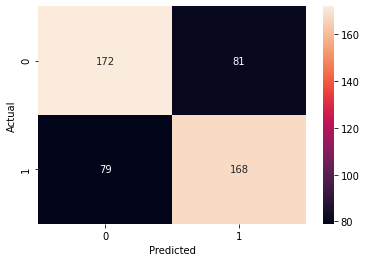

In [23]:
#plotting confusion matrix
cm = confusion_matrix(df_2['dank_or_not'], labels)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()